In [8]:
# wiomenmoxingfaileddezuoweijiaqiangxunlian GAN, shencheng shibiebuliaodehuibengdiao

In [9]:
import os

In [91]:
# when writing log, thought about what if we make it different so we flip the color
from PIL import Image
import os
import imageio.v2 as imageio
import numpy as np
import cv2

path = "/home/wg25r/fastdata/fullmoca/MoCA-Video-Train/"
rgb_dir = "./video_rgb_"
alpha_dir = "./video_alpha"

if os.path.exists(rgb_dir):
    os.system(f"rm -rf {rgb_dir}")
os.makedirs(rgb_dir)

if os.path.exists(alpha_dir):
    os.system(f"rm -rf {alpha_dir}")
os.makedirs(alpha_dir)

# for video in os.listdir(path):
def process_video(video):
    frame_dir = os.path.join(path, video, "Frame")
    gt_dir = os.path.join(path, video, "GT")
    if not (os.path.isdir(frame_dir) and os.path.isdir(gt_dir)):
        return
    frames = sorted(f for f in os.listdir(frame_dir) if f.lower().endswith(".jpg"))
    if len(frames) < 37:
        print(f"Video {video} has less than 37 frames, skipping...")
        return

    for idx in range(len(frames) // 37):
        seg_frames = frames[idx * 37:(idx + 1) * 37]

        rgb_out_path = os.path.join(rgb_dir, f"{video}_{idx:03d}.mp4")
        writer_rgb = imageio.get_writer(rgb_out_path, fps=24)
        for i, f in enumerate(seg_frames):
            img = imageio.imread(os.path.join(frame_dir, f))
            img_resized = Image.fromarray(img).resize((848, 480))
            writer_rgb.append_data(np.array(img_resized).astype(np.uint8))
        writer_rgb.close()

        alpha_out_path = os.path.join(alpha_dir, f"{video}_{idx:03d}.mp4")
        writer_alpha = imageio.get_writer(alpha_out_path, fps=24)
        for i, f in enumerate(seg_frames):
            alpha_name = os.path.splitext(f)[0] + '.png'
            mask = np.array(imageio.imread(os.path.join(gt_dir, alpha_name)))
            mask_resized = cv2.resize(mask, (848, 480), interpolation=cv2.INTER_NEAREST)
            img = np.array(imageio.imread(os.path.join(frame_dir, f)))
            img = cv2.resize(img, (848, 480), interpolation=cv2.INTER_NEAREST)
            foreground = np.where(mask_resized[:,:,None] > 0, img, 0).astype(int)
            foreground = 50 + foreground
            foreground = np.clip(foreground, 0, 255).astype(np.uint8)
            
            background = np.where(mask_resized[:,:,None] == 0, img * 0.2 , 0).astype(np.uint8)
            background = cv2.GaussianBlur(background, (5, 5), 0)

                        
            img_clipped = np.where(mask_resized[:,:,None] > 0, foreground, background)
                        
            writer_alpha.append_data(img_clipped.astype(np.uint8))
        writer_alpha.close()
    return img_clipped.astype(int), np.array(img_resized).astype(int)


In [92]:
videos = os.listdir(path)

a, b = process_video(videos[5]) 

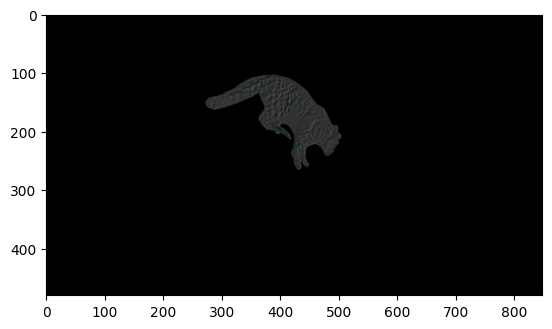

In [93]:
import matplotlib.pyplot as plt
plt.imshow(np.clip(a - b, 0, 255))

In [94]:

# use a pool of 64 processes
from multiprocessing import Pool
pool = Pool(processes=64)
# map the function to the list of videos
pool.map(process_video, videos)
pool.close()
pool.join() 

Video flounder_3 has less than 37 frames, skipping...


In [ ]:
from openai import OpenAI
from PIL import Image
import io
import base64

def capture_image(imgs, filename):
    
    client = OpenAI()
    
    base64s = []
    for img in imgs:
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG")
        image_data = buffer.getvalue()
        base64_image = base64.b64encode(image_data).decode('utf-8')
        image_url = f"data:image/jpeg;base64,{base64_image}"
        base64s.append(image_url)
        
    response = client.chat.completions.create(
    model="gpt-4.1",
    messages=[
        {
        "role": "user",
        "content": [
            *[{
            "type": "image_url",
            "image_url": {
                "url": image_url
            }
            } for image_url in base64s],
            {
            "type": "text",
            "text": "Describe in 2-3 setence this image such that the prompt will be used to generate an video. Mention motion, the object might be hard to see. the filename is " + filename + ", filename might has other things than the animal. Do not mention filename just the animal name. The object might be hard to see (mention this) and blended into the envirement. Mention the animal is camflague and blend into the envirement for texture, color, and shape. Mention the animal's motion, but do not mention this makes it easy to spot."
            }
        ]
        },
    ],
    )
    return response.choices[0].message.content

import os
import cv2
videos = os.listdir("./video_rgb_")

def get_prompt(video):
    video_path = os.path.join("./video_rgb", video)
    
    cap = cv2.VideoCapture(video_path)
    frames = []
    # get first, middle, and last frame
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    middle_frame = total_frames // 2
    for i in [0, middle_frame, total_frames - 1]:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
    cap.release()
    # Convert frames to PIL images
    imgs = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in frames]
    # Capture image and get prompt
    prompt = capture_image(imgs, video) 
    
    with open(os.path.join("./video_rgb", video.replace(".mp4", ".txt")), "w") as f:
        f.write(prompt)
    print(prompt)
    return prompt
videos = os.listdir("./video_rgb")

# use a pool of 30 processes
from multiprocessing import Pool
if __name__ == "__main__":
    with Pool(30) as p:
        prompts = p.map(get_prompt, videos)
    print(prompts)

# get_prompt("crab_1_000.mp4")

The video shows a flatfish camouflaged against the sandy ocean floor, making it difficult to see due to its coloration, texture, and shape blending seamlessly with its environment. As the video progresses, the flatfish slowly glides forward across the seabed. Its subtle movement is the only indication of its presence as it remains perfectly integrated with the surrounding terrain.
A snow leopard, nearly invisible due to its expert camouflage, moves silently across a rocky, arid slope. Its fur blends seamlessly with the texture, color, and shape of the surrounding stones and dry grass, making it difficult to distinguish from the environment. The snow leopard is making slow, deliberate movements as it navigates the rugged terrain.
A peacock flounder swims smoothly across a sandy and rocky ocean floor, its flat body almost perfectly camouflaged and blended into the environment with matching texture, color, and shape. The flounder’s speckled pattern and form make it difficult to see as it 